### О ЛР:

- Coding Gradient boosting

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку (Она тут равняется 6).

**Оценка**:

***DeadLine - 28.05.2024 23:59***

### Формат сдачи
Задания сдаются через lms. Вы прикрепляете **ССЫЛКУ НА ПУБЛИЧНЫЙ РЕПОЗИТОРИЙ**, где выполнено ваше задание. Иначе задание не проверяется.

In [1]:
from warnings import filterwarnings

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.sparse import load_npz
from sklearn.model_selection import train_test_split


sns.set(style="darkgrid")
filterwarnings("ignore")

C:\Users\nrww\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
x = load_npz("x.npz")
y = np.load("y.npy")

Разделим на обучающую, валидационную и тестовую выборки (`random_state` оставьте равным 666 для воспроизводимости).

In [3]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=666
)

x_test, x_valid, y_test, y_valid = train_test_split(
    x_test, y_test, test_size=0.5, random_state=666
)

x_train.shape, x_valid.shape, x_test.shape

((18825, 169), (2354, 169), (2353, 169))

## Задание 1. Реализация градиентного бустинга [2 балла]

Необходимо дописать код в файле `boosting.py`. Уже создан шаблон класса `Boosting`, который можно модифицировать по своему усмотрению.

### Описание функций:

#### `__init__`

Конструктор класса принимает следующие параметры:

- `base_model_class` — класс базовой модели для бустинга.
- `base_model_params` — словарь гиперпараметров для базовой модели.
- `n_estimators` — количество базовых моделей для обучения.
- `learning_rate` — темп обучения, должен быть в диапазоне (0, 1].
- `subsample` — доля обучающей выборки для тренировки базовой модели (размер бутстрап-выборки относительно исходной).
- `early_stopping_rounds` — число итераций без улучшения на валидационной выборке, после которых обучение прекращается.
- `plot` — флаг для построения графика качества моделей после обучения.

#### `fit`

Метод `fit` принимает обучающую и валидационную выборки.

1. Инициализируем нулевую модель и делаем предсказания (например, все нули) для обеих выборок.
2. Обучаем `n_estimators` базовых моделей:
   - Обучаем новую базовую модель на текущих остатках.
   - Обновляем предсказания на обучающей и валидационной выборках.
   - Рассчитываем ошибки на обеих выборках с помощью `loss_fn`.
   - Проверяем условия для ранней остановки.

3. Если флаг `plot` установлен, строим график качества после обучения всех моделей.

#### `fit_new_base_model`

Метод `fit_new_base_model` принимает обучающую выборку и текущие предсказания для неё.

1. Генерируем бутстрап-выборку.
2. Обучаем базовую модель на этой выборке.
3. Оптимизируем значение гаммы.
4. Добавляем новую базовую модель и гамму в соответствующие списки (учитывая `learning_rate`).

#### `predict_proba`

Метод `predict_proba` принимает выборку для предсказания вероятностей.

1. Суммируем предсказания базовых моделей (учитывая гамму и `learning_rate`).
2. Применяем сигмоидальную функцию для получения вероятностей.

In [4]:
%load_ext autoreload

In [5]:
%autoreload 2

from boosting import Boosting

### Проверка кода

У автора задания всё учится около одной секунды.

In [6]:
boosting = Boosting()

%time boosting.fit(x_train, y_train, x_valid, y_valid)

assert len(boosting.models) == boosting.n_estimators
assert len(boosting.gammas) == boosting.n_estimators

assert boosting.predict_proba(x_test).shape == (x_test.shape[0], 2)

print(f'Train ROC-AUC {boosting.score(x_train, y_train):.4f}')
print(f'Valid ROC-AUC {boosting.score(x_valid, y_valid):.4f}')
print(f'Test ROC-AUC {boosting.score(x_test, y_test):.4f}')

CPU times: total: 1 s
Wall time: 1.04 s
Train ROC-AUC 0.9870
Valid ROC-AUC 0.9441
Test ROC-AUC 0.9474


## Задание 2. Обучение градиентного бустинга [0.5 балла]

Оцените качество вашей реализации градиентного бустинга на тестовой выборке, используя базовые модели — решающие деревья с различной максимальной глубиной. Метрикой будет ROC-AUC.

**Инструкция:**
1. Перебирайте значения максимальной глубины деревьев от 1 до 30 с шагом 2.
2. Оставьте остальные параметры бустинга по умолчанию.
3. Постройте график зависимости качества на обучающей и тестовой выборке от максимальной глубины деревьев.

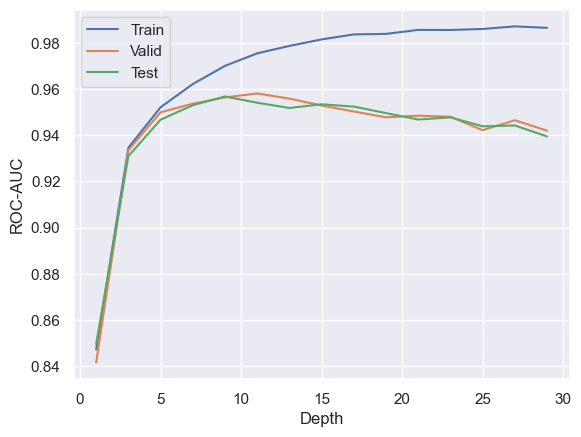

In [7]:
results = {}
hist_train = {}
hist_val = {}
hist_test = {}

depths = range(1, 30, 2)
for depth in depths:
    boosting = Boosting(base_model_params={'max_depth':depth})
    boosting.fit(x_train, y_train, x_valid, y_valid)
    hist_train[depth] = boosting.score(x_train, y_train)
    hist_val[depth] = boosting.score(x_valid, y_valid)
    hist_test[depth] = boosting.score(x_test, y_test)

plt.plot(hist_train.keys(), hist_train.values(), label='Train')
plt.plot(hist_val.keys(), hist_val.values(), label='Valid')
plt.plot(hist_test.keys(), hist_test.values(), label='Test')
plt.legend()
plt.xlabel('Depth')
plt.ylabel('ROC-AUC')
plt.show()
### ╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ

**Какая из моделей имеет лучшее качество? Как вы можете это объяснить?**

Наилучшее качество имеет модель на деревьях глубины 8. Это связанно с тем, что менее глубокие деревья запоминают слишком мало закономерностей из обучающей выборки и слишком медленно улучшают бустинг, а более глубокие деревья переобучаются на данных и теряют способность к генерализации.

## Задание 3. Подбор гиперпараметров и поиск оптимальной модели [3 балла]

Настройте основные гиперпараметры вашей модели градиентного бустинга, используя валидационную выборку. Подберите параметры как для самого бустинга, так и для базовых моделей.

**Рекомендации:**
- Используйте библиотеки для автоматизированного подбора гиперпараметров, такие как [Hyperopt](https://github.com/hyperopt/hyperopt) или [Optuna](https://optuna.org/).
- Подберите все основные параметры, чтобы найти лучшую модель на валидационной выборке.

In [8]:
### ╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ
import optuna

def objective(trial):
    max_depth = trial.suggest_int('max_depth', 2, 25)
    n_estimators = trial.suggest_int('n_estimators', 5, 250)
    learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.4)
    subsample = trial.suggest_uniform('subsample', 0.2, 1.0)

    boosting = Boosting(
        base_model_params={'max_depth': max_depth},
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        subsample=subsample,
        early_stopping_rounds=5
    )

    boosting.fit(x_train, y_train, x_valid, y_valid)
    score = boosting.score(x_valid, y_valid)

    return score

sampler = optuna.samplers.TPESampler(seed=37)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=100, n_jobs=-1)

print(f'Hyperparameters: {study.best_params}')
print(f'Valid ROC-AUC score: {study.best_value}')

boosting = Boosting(
    base_model_params={'max_depth': study.best_params['max_depth']},
    n_estimators=study.best_params['n_estimators'],
    learning_rate=study.best_params['learning_rate'],
    subsample=study.best_params['subsample'],
    early_stopping_rounds=5
)

boosting.fit(x_train, y_train, x_valid, y_valid)

test_roc_auc = boosting.score(x_test, y_test)
print(f'Test ROC-AUC score: {test_roc_auc}')

[I 2024-06-10 16:37:43,943] A new study created in memory with name: no-name-82df28c1-78a6-4246-b355-790e0c71bf21
[I 2024-06-10 16:37:48,860] Trial 6 finished with value: 0.9572393229851794 and parameters: {'max_depth': 4, 'n_estimators': 54, 'learning_rate': 0.3188980103428011, 'subsample': 0.2815322291407431}. Best is trial 6 with value: 0.9572393229851794.
[I 2024-06-10 16:37:53,688] Trial 8 finished with value: 0.9425353358574593 and parameters: {'max_depth': 2, 'n_estimators': 96, 'learning_rate': 0.16198602816775665, 'subsample': 0.8401183012244944}. Best is trial 6 with value: 0.9572393229851794.
[I 2024-06-10 16:37:54,172] Trial 16 finished with value: 0.9507997514002798 and parameters: {'max_depth': 4, 'n_estimators': 43, 'learning_rate': 0.1367151287812699, 'subsample': 0.8307400684051804}. Best is trial 6 with value: 0.9572393229851794.
[I 2024-06-10 16:37:58,926] Trial 7 finished with value: 0.965779409690051 and parameters: {'max_depth': 8, 'n_estimators': 210, 'learning_r

Hyperparameters: {'max_depth': 6, 'n_estimators': 177, 'learning_rate': 0.3384311517510116, 'subsample': 0.7169033326524586}
Valid ROC-AUC score: 0.966943862980375
Test ROC-AUC score: 0.9664101290568043


## Задание 4. Интерпретация градиентного бустинга [1 балл]

Постройте калибровочную кривую для вашей лучшей модели градиентного бустинга и оцените, насколько точно модель предсказывает вероятности.

**Инструкция:**
1. Постройте калибровочную кривую для лучшей модели градиентного бустинга.
2. Постройте аналогичную кривую для логистической регрессии.
3. Сравните полученные результаты и проанализируйте, насколько хорошо каждая модель оценивает вероятности.

In [9]:
def plot_calibration_curve(y_test, preds, classifier_name='Some Classifier', ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))
        
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        
        bin_middle_points.append((l + r) / 2)
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1))
    ax.plot(bin_middle_points, bin_real_ratios, label=classifier_name)
    ax.set_ylim([-0.05, 1.05])
    ax.legend()
    ax.grid(visible=True)

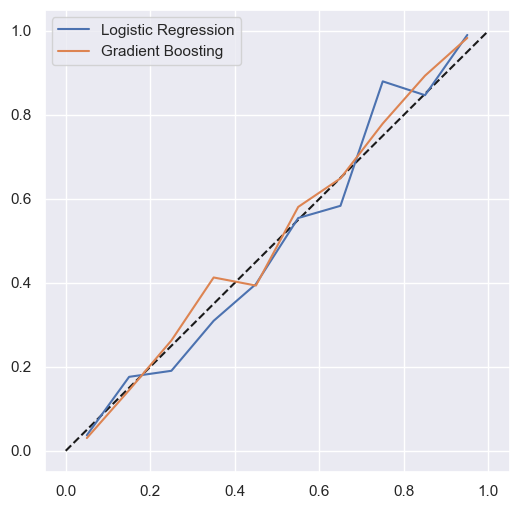

In [10]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(x_train, y_train)
y_pred_prob_log_reg = log_reg.predict_proba(x_test)[:, 1]
y_pred_prob_boosting = boosting.predict_proba(x_test)[:, 1]

_, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(np.linspace(0,1,2), np.linspace(0,1,2),'k--')
plot_calibration_curve(y_test, y_pred_prob_log_reg, classifier_name="Logistic Regression", ax=ax)
plot_calibration_curve(y_test, y_pred_prob_boosting,classifier_name="Gradient Boosting", ax=ax)


Кака видим из графика, линия бустинга находится ближе к диагонали, чем линия логистической регрессии. Следовательно бустинг точнее предсказывает вероятности

Теперь оценим важность признаков для градиентного бустинга.

**Задание:**
1. Поскольку базовая модель — дерево из `sklearn`, вычислите важность каждого признака для каждого дерева, используя атрибут `feature_importances_` у `DecisionTreeRegressor`.
2. Усредните значения важности по всем деревьям и нормализуйте их так, чтобы сумма была равна единице (убедитесь, что значения неотрицательны).
3. Дополните вашу реализацию бустинга, добавив метод `feature_importances_`, который будет возвращать усредненные и нормализованные важности признаков.

**Построение графиков:**
1. Постройте столбчатую диаграмму важности признаков для градиентного бустинга.
2. На соседнем графике изобразите важность признаков для логистической регрессии, используя модули весов.
3. Сравните графики и проанализируйте полученные результаты.

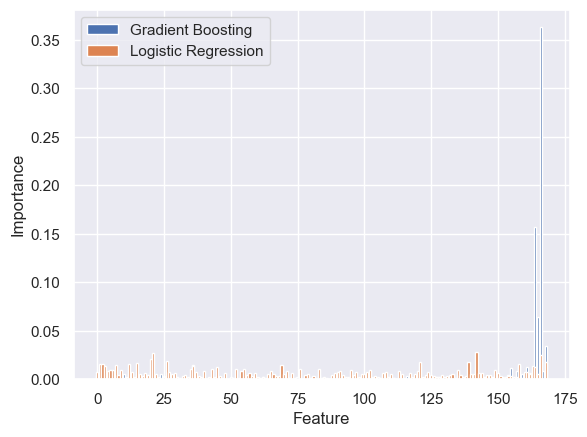

In [11]:
### ╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ
boosting_feature_importances = boosting.feature_importances_

log_reg_feature_importances = np.abs(log_reg.coef_[0])
log_reg_feature_importances /= log_reg_feature_importances.sum()
n_features = len(boosting_feature_importances)

plt.bar(np.arange(n_features), boosting_feature_importances, label='Gradient Boosting')
plt.bar(np.arange(n_features), log_reg_feature_importances, label='Logistic Regression')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.legend()
plt.show()

Как видим из графика, логистическая регрессия равномерно использует практически все фичи, в то время как бустинг выделил наиболее важные, и приемущественно использует их.

Обычно избыточные признаки могут негативно влиять на качество бустинга. Попробуйте следующее:

1. **Отфильтруйте неважные признаки:** Используйте построенную диаграмму важности признаков, чтобы отобрать наиболее незначительные признаки.
2. **Обучите модель повторно:** Обучите модель на основе оставшихся признаков с теми же гиперпараметрами.
3. **Оцените качество модели:** Сравните результаты новой модели с исходной. Улучшилось ли качество после отфильтровывания незначительных признаков?

In [12]:
### ╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ
limits = [0.05, 0.01, 0.001, 0.0001]
for limit in limits:
    filt_ind = np.where(boosting_feature_importances > limit)[0]
    print(f'Selected {len(filt_ind)/x_test.shape[1]*100:.2f}% features')
    
    filt_boosting = Boosting(
        base_model_params={'max_depth': study.best_params['max_depth']},
        n_estimators=study.best_params['n_estimators'],
        learning_rate=study.best_params['learning_rate'],
        subsample=study.best_params['subsample'],
        early_stopping_rounds=5
    )

    filt_boosting.fit(x_train[:, filt_ind], y_train, x_valid[:, filt_ind], y_valid)
    filt_test_roc_auc = filt_boosting.score(x_test[:, filt_ind], y_test)
    
    print(f'Filtered test ROC-AUC score: {filt_test_roc_auc}')
    
orig_test_roc_auc = boosting.score(x_test, y_test)
print(f'Original test ROC-AUC score: {orig_test_roc_auc}')


Selected 1.78% features
Filtered test ROC-AUC score: 0.941061220396292
Selected 4.73% features
Filtered test ROC-AUC score: 0.9545200923949294
Selected 62.72% features
Filtered test ROC-AUC score: 0.9648182109068679
Selected 87.57% features
Filtered test ROC-AUC score: 0.9652014652014653
Original test ROC-AUC score: 0.9664101290568043


Как видим из результатов, даже отбрасив менее 13% самых "неважных" фич, результаты ухудшаются. Видимо, даже если фичи имеют низкую важность, они все равно вносят вклад в результат

## Задание 5 (бонус). Блендинговое [0.5 балла]

Реализуйте блендинг над вашей лучшей моделью и логистической регрессией. Улучшилось ли качество?

In [13]:
from sklearn.metrics import roc_auc_score
### ╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ
y_pred_prob_boosting_valid = boosting.predict_proba(x_valid)[:, 1]
y_pred_prob_log_reg_valid = log_reg.predict_proba(x_valid)[:, 1]
blend_x_train = np.vstack((y_pred_prob_boosting_valid, y_pred_prob_log_reg_valid)).T

y_pred_prob_boosting_test = boosting.predict_proba(x_test)[:, 1]
y_pred_prob_log_reg_test = log_reg.predict_proba(x_test)[:, 1]
blend_x_test = np.vstack((y_pred_prob_boosting_test, y_pred_prob_log_reg_test)).T

blend = LogisticRegression()
blend.fit(blend_x_train, y_valid)
y_pred_prob_blend_test = blend.predict_proba(blend_x_test)[:, 1]

roc_auc_blend = roc_auc_score(y_test, y_pred_prob_blend_test)
roc_auc_boosting = roc_auc_score(y_test, y_pred_prob_boosting_test)
roc_auc_log_reg = roc_auc_score(y_test, y_pred_prob_log_reg_test)

print(f'Blending test ROC-AUC score: {roc_auc_blend}')
print(f'Gradient Boosting test ROC-AUC score: {roc_auc_boosting}')
print(f'Logistic Regression test ROC-AUC score: {roc_auc_log_reg}')

Blending test ROC-AUC score: 0.9668952661129976
Gradient Boosting test ROC-AUC score: 0.9664101290568043
Logistic Regression test ROC-AUC score: 0.9622659681329824


Как видим, качество немного улучшилось!

## Задание 6 (бонус). Катбустовое [0.5 балла]

Запустите [CatBoost](https://catboost.ai/en/docs/concepts/python-quickstart) на наших данных, сравните с вашей реализацией. Где получилось лучше?

In [14]:
### ╰( ͡☉ ͜ʖ ͡☉ )つ──☆*:・ﾟ   ฅ^•ﻌ•^ฅ   ʕ•ᴥ•ʔ
from catboost import CatBoostClassifier

cat_model = CatBoostClassifier()

cat_model.fit(x_train, y_train, eval_set=(x_valid, y_valid))

y_pred_prob_cat_test = cat_model.predict_proba(x_test)[:, 1]
roc_auc_cat = roc_auc_score(y_test, y_pred_prob_cat_test)

print(f'CatBoost test ROC-AUC score: {roc_auc_cat}')
print(f'Blending test ROC-AUC score: {roc_auc_blend}')
print(f'Gradient Boosting test ROC-AUC score: {roc_auc_boosting}')
print(f'Logistic Regression test ROC-AUC score: {roc_auc_log_reg}')

Learning rate set to 0.065429
0:	learn: 0.6213921	test: 0.6225645	best: 0.6225645 (0)	total: 7.54ms	remaining: 7.54s
1:	learn: 0.5609945	test: 0.5639047	best: 0.5639047 (1)	total: 14.1ms	remaining: 7.04s
2:	learn: 0.5167671	test: 0.5206745	best: 0.5206745 (2)	total: 20.5ms	remaining: 6.82s
3:	learn: 0.4780357	test: 0.4830126	best: 0.4830126 (3)	total: 27.7ms	remaining: 6.9s
4:	learn: 0.4487606	test: 0.4547073	best: 0.4547073 (4)	total: 34.4ms	remaining: 6.85s
5:	learn: 0.4214896	test: 0.4284540	best: 0.4284540 (5)	total: 41.8ms	remaining: 6.93s
6:	learn: 0.4018447	test: 0.4094383	best: 0.4094383 (6)	total: 48.8ms	remaining: 6.92s
7:	learn: 0.3832229	test: 0.3907748	best: 0.3907748 (7)	total: 55.7ms	remaining: 6.9s
8:	learn: 0.3683590	test: 0.3761752	best: 0.3761752 (8)	total: 62.5ms	remaining: 6.88s
9:	learn: 0.3545867	test: 0.3625866	best: 0.3625866 (9)	total: 69.4ms	remaining: 6.87s
10:	learn: 0.3447224	test: 0.3531405	best: 0.3531405 (10)	total: 76ms	remaining: 6.83s
11:	learn: 0.33

Катбустовое победило(

Оставьте пожалуйста отзыв о курсе!

https://forms.gle/LajA3Xrps6u96Q5A8


Это очень важно. Благодаря обратной связи мы будем двигаться в сторону антиградиента)


Максимальная оценка 6 баллов